In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle

In [2]:


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = 2 * N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 8  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [4]:
#Generate hamiltonian for 2x2x2 orbital Kane-Mele model

NN_list = np.array([(1,2), (2, 3), (3,4), (5, 6), (5, 8), (7, 8), (2, 5)]) - 1
NNN_list = np.array([(1, 3), (5, 7), (1, 5), (1, 7), (2, 8), (4, 6), (2, 4), (6, 8), (2, 6)]) - 1

a = np.array([[1, 0],[-1/2, np.sqrt(3)/2],[-1/2, np.sqrt(3)/2]])
b = np.array([[0, np.sqrt(3)],[3/2, -np.sqrt(3)/2],[-3/2, -np.sqrt(3)/2]])


def g(k):
    return np.sum(np.exp(1j*a@k))

def g_bar(k, phi_h, sign):
    return np.sum(np.exp(1j*b@k))*np.exp(sign*1j*phi_h)

def hamil(t, mu, U, l_so, phi_h, k):
    hamiltonian = sp.csr_matrix((4**N, 4**N), dtype=complex)
    g_k = g(k)
    g_bar_k_up = g_bar(k, phi_h, 1)
    g_bar_k_down = g_bar(k, phi_h, -1)
    for NN in NN_list:
        hamiltonian+=(cdags[NN[0]*2]@cs[NN[1]*2]*g_k + cdags[NN[1]*2]@cs[NN[0]*2]*np.conj(g_k))*t*-1
        hamiltonian+=(cdags[NN[0]*2+1]@cs[NN[1]*2+1]*g_k + cdags[NN[1]*2+1]@cs[NN[0]*2+1]*np.conj(g_k))*t*-1
    for NNN in NNN_list:
        hamiltonian+=(cdags[NNN[0]*2]@cs[NNN[1]*2]*g_bar_k_down + cdags[NNN[1]*2]@cs[NNN[0]*2]*np.conj(g_bar_k_down))*l_so
        hamiltonian+=(cdags[NNN[0]*2+1]@cs[NNN[1]*2+1]*g_bar_k_up + cdags[NNN[1]*2+1]@cs[NNN[0]*2+1]*np.conj(g_bar_k_up))*l_so
    for i in range(N):
        hamiltonian+=cdags[i*2]@cs[i*2]@cdags[i*2+1]@cs[i*2+1]*U
        hamiltonian+=-mu*(cdags[i*2]@cs[i*2]+cdags[i*2+1]@cs[i*2+1])
    
    return hamiltonian

In [5]:
test_hamil = hamil(1, 5, 10, 0.3, np.pi/2, (np.pi,np.pi))

In [6]:
evals, evecs = sp.linalg.eigsh(test_hamil, return_eigenvectors=True, which='SR')

In [7]:
cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)

In [8]:
evecs[:,:cutoff]

array([[ 3.60511918e-18+7.93608817e-21j],
       [-2.40039389e-18-2.49499821e-18j],
       [-2.14976589e-18+2.40149841e-18j],
       ...,
       [ 2.97530871e-19-1.13919361e-18j],
       [ 3.64707921e-18-3.81645702e-18j],
       [ 5.24832410e-18-1.99310243e-18j]], shape=(65536, 1))

In [9]:
def get_occupancy(t, U, mu, l_so, phi_h, k_num):
    
    k_range = np.arange(k_num)/k_num

    kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    
    occ_sum = 0
    acc = 1
    for kx in kx_range:
        for ky in ky_range:
            #print(str(acc)+"/"+str(k_num**2)); acc+=1;
            k = kx+ky
            hamil_k = hamil(t, mu, U, l_so, phi_h, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, return_eigenvectors=True, which='SR', k=4)
            cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)
            if cutoff>1: print(cutoff)
            gs_vecs = evecs[:,:cutoff]
            for i in range(2*N):
                occ_sum += (gs_vecs.conj().T@cdags[i]@cs[i]@gs_vecs).sum()/cutoff 
    
    return occ_sum/(k_num**2)/(2*N)

In [16]:
t = 1
U = 0
mu = U/2+1
l_so = 0.3
k_num = 10
phi_h = 0.81*np.pi

mu_range = np.linspace(-2*t, 2*t, 30)
occ_array = np.zeros_like(mu_range)

for ind, mu in enumerate(mu_range):
    print(ind, len(mu_range)-1)
    occ_array[ind] = get_occupancy(t, U, mu, l_so, phi_h, k_num)

0 29


KeyboardInterrupt: 

In [12]:
data_dict = {'mu':mu_range, 'occ':occ_array}

Text(0, 0.5, '$n_{occ}$ (Occupancy)')

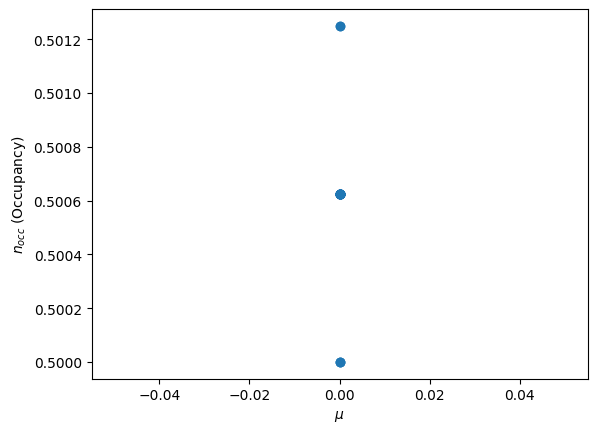

In [13]:
with open('trivial.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)

plt.scatter(data_dict['mu'], data_dict['occ'])
plt.xlabel(r"$\mu$")
plt.ylabel(r"$n_{occ}$ (Occupancy)")

In [14]:
occ_array

array([0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.500625,
       0.5     , 0.500625, 0.500625, 0.500625, 0.50125 , 0.500625,
       0.500625, 0.500625, 0.500625, 0.500625, 0.5     , 0.500625,
       0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.5     ,
       0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.50125 ])

In [17]:
occ_array
lambda_so = 0.3
phi = 0.81*np.pi


array([0.03757812, 0.04359375, 0.05625   , 0.06242188, 0.0646875 ,
       0.074375  , 0.08851562, 0.12242187, 0.14007813, 0.17390625,
       0.20046875, 0.2125    , 0.23454096, 0.25007812, 0.27700859,
       0.32156429, 0.37500572, 0.37499156, 0.39701204, 0.41598055,
       0.48148438, 0.48523438, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [75]:
k_num = 20

k_range = (np.arange(k_num)-k_num/2)/k_num

kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]

(-7.0, 7.0)

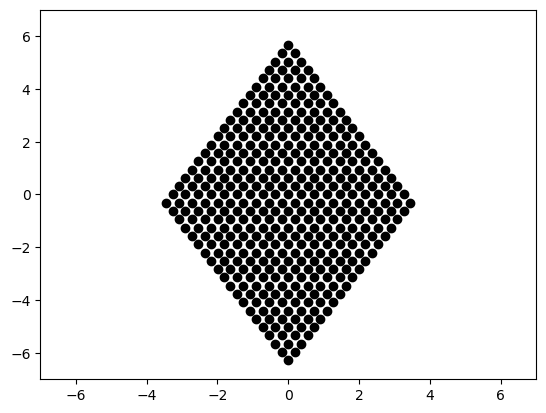

In [78]:

for kx in kx_range:
    for ky in ky_range:
        k = kx+ky
        #print(k[0], k[1])
        plt.scatter([k[0]], [k[1]], c='k')
        
plt.xlim(-7, 7)
plt.ylim(-7, 7)